In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data

In [ ]:
# @title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [ ]:
# @title Data loading
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,
                      np.load('steinmetz_part%d.npz'%j,
                              allow_pickle=True)['dat']))



alldat contains 39 sessions from 10 mice, data from Steinmetz et al, 2019. Time bins for all measurements are 10ms, starting 500ms before stimulus onset. The mouse had to determine which side has the highest contrast. For each dat = alldat[k], you have the fields below. For extra variables, check out the extra notebook and extra data files (lfp, waveforms and exact spike times, non-binned).

    dat['mouse_name']: mouse name
    dat['date_exp']: when a session was performed
    dat['spks']: neurons by trials by time bins.
    dat['brain_area']: brain area for each neuron recorded.
    dat['ccf']: Allen Institute brain atlas coordinates for each neuron.
    dat['ccf_axes']: axes names for the Allen CCF.
    dat['contrast_right']: contrast level for the right stimulus, which is always contralateral to the recorded brain areas.
    dat['contrast_left']: contrast level for left stimulus.
    dat['gocue']: when the go cue sound was played.
    dat['response_time']: when the response was registered, which has to be after the go cue. The mouse can turn the wheel before the go cue (and nearly always does!), but the stimulus on the screen won't move before the go cue.
    dat['response']: which side the response was (-1, 0, 1). When the right-side stimulus had higher contrast, the correct choice was -1. 0 is a no go response.
    dat['feedback_time']: when feedback was provided.
    dat['feedback_type']: if the feedback was positive (+1, reward) or negative (-1, white noise burst).
    dat['wheel']: turning speed of the wheel that the mice uses to make a response, sampled at 10ms.
    dat['pupil']: pupil area (noisy, because pupil is very small) + pupil horizontal and vertical position.
    dat['face']: average face motion energy from a video camera.
    dat['licks']: lick detections, 0 or 1.
    dat['trough_to_peak']: measures the width of the action potential waveform for each neuron. Widths <=10 samples are "putative fast spiking neurons".
    dat['%X%_passive']: same as above for X = {spks, pupil, wheel, contrast_left, contrast_right} but for passive trials at the end of the recording when the mouse was no longer engaged and stopped making responses.
    dat['prev_reward']: time of the feedback (reward/white noise) on the previous trial in relation to the current stimulus time.
    dat['reaction_time']: ntrials by 2. First column: reaction time computed from the wheel movement as the first sample above 5 ticks/10ms bin. Second column: direction of the wheel movement (0 = no move detected).

The original dataset is here: https://figshare.com/articles/dataset/Dataset_from_Steinmetz_et_al_2019/9598406


Q1: How many unique mice are used in these 39 sessions? Name them

Q2: Which mouse took part in most sessions? And which the least? Make a bar plot to visualize the same

Q3: On average, how many sessions does a mouse take part in?

In [ ]:
mouse_names = [dat['mouse_name'] for dat in alldat]

In [ ]:
unique_mice = {dat['mouse_name'] for dat in alldat}

In [ ]:
from collections import defaultdict
mice = {}
for um in unique_mice:
  mice[um] = mouse_names.count(um)

In [ ]:
mice

{'Lederberg': 7,
 'Tatum': 4,
 'Muller': 3,
 'Radnitz': 5,
 'Forssmann': 4,
 'Theiler': 1,
 'Richards': 5,
 'Moniz': 3,
 'Cori': 3,
 'Hench': 4}

In [ ]:
np.median([val for val in mice.values()])

4.0

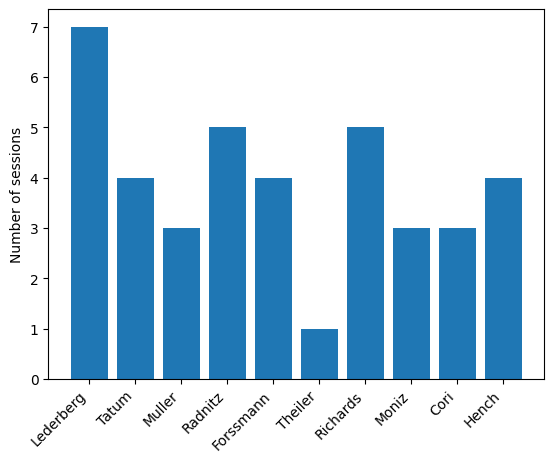

In [ ]:
import matplotlib.pyplot as plt

plt.bar(x=mice.keys(),height=mice.values())
plt.ylabel("Number of sessions")
plt.xticks(rotation=45, ha='right');

Q1: as a group, when the correct response was no-go, </br>
    1. what's the percentage of left turn?</br>
    2. what's the percentage of right turn?</br>
    3. what's the percentage of correct response?</br>

Same for left and right correct responses

In [ ]:
responses = []
feedbacks = []
mice = []
contrast_diffs = []
wheel_turns = []
for session in alldat:
  mice.extend([session["mouse_name"]]*len(session["response"]))
  responses.extend(session["response"])
  feedbacks.extend(session["feedback_type"])
  contrast_diffs.extend(np.array(session["contrast_left"]) - np.array(session['contrast_right']))


allmice = pd.DataFrame(data = {
    "mouse":mice,
    "response":responses,
    "feedback":feedbacks,
    "contrast_diff":np.array(contrast_diffs).flatten(),
})


In [ ]:
def contrast(df):
  if df.contrast_diff == 0.:
    return 0
  elif df.contrast_diff > 0.:
    return 1 # go right, left has higher contrast
  else:
    return -1 # go left


In [ ]:
allmice["correct"] = allmice.apply(contrast, axis=1)

In [ ]:
allmice

,mouse,response,feedback,contrast_diff,correct
0,Cori,1.0,1.0,1.00,1
1,Cori,-1.0,1.0,-0.50,-1
2,Cori,1.0,1.0,0.50,1
3,Cori,0.0,1.0,0.00,0
4,Cori,1.0,-1.0,-0.50,-1
...,...,...,...,...,...
10045,Theiler,0.0,-1.0,0.75,1
10046,Theiler,-1.0,-1.0,0.75,1
10047,Theiler,0.0,-1.0,0.75,1
10048,Theiler,0.0,-1.0,0.75,1


In [ ]:
grouped_zero = allmice[allmice["correct"] == 0][["mouse","response","contrast_diff"]].groupby(by=["mouse","response"]).count()

In [ ]:
total_nogo_trials = grouped_zero.groupby(level=1)['contrast_diff'].sum().sum()
grouped_zero.groupby(level=1)['contrast_diff'].sum()*100/total_nogo_trials


response
-1.0    23.818127
 0.0    56.669678
 1.0    19.512195
Name: contrast_diff, dtype: float64

In [ ]:
grouped_left = allmice[allmice["correct"] == -1][["mouse","response","contrast_diff"]].groupby(by=["mouse","response"]).count()

In [ ]:
total_left_trials = grouped_left.groupby(level=1)['contrast_diff'].sum().sum()
grouped_left.groupby(level=1)['contrast_diff'].sum()*100/total_left_trials

response
-1.0    72.475669
 0.0    20.012165
 1.0     7.512165
Name: contrast_diff, dtype: float64

In [ ]:
grouped_right = allmice[allmice["correct"] == 1][["mouse","response","contrast_diff"]].groupby(by=["mouse","response"]).count()

In [ ]:
total_right_trials = grouped_right.groupby(level=1)['contrast_diff'].sum().sum()
grouped_right.groupby(level=1)['contrast_diff'].sum()*100/total_right_trials

response
-1.0     5.783203
 0.0    22.231909
 1.0    71.984888
Name: contrast_diff, dtype: float64

Q1: when the correct response is no-go, which mouse/mice, </br>
    1. has best performance?</br>
    2. worst performance?</br>

Same for left and right correct responses

In [ ]:
grouped_zero_reset = grouped_zero.reset_index()
summed_contrast_diff_reset = grouped_zero.groupby(level=0)['contrast_diff'].sum().reset_index()

merged_zero = grouped_zero_reset.merge(summed_contrast_diff_reset, on="mouse")

merged_zero.set_index(["mouse", "response"], inplace=True)

merged_zero["percent"] = np.round(merged_zero["contrast_diff_x"]*100./merged_zero["contrast_diff_y"])
merged_zero.rename(columns={"contrast_diff_x": "response_counts", "contrast_diff_y": "total_trials_per_mouse"}, inplace=True)

In [ ]:
grouped_left_reset = grouped_left.reset_index()
summed_contrast_diff_reset = grouped_left.groupby(level=0)['contrast_diff'].sum().reset_index()

merged_left = grouped_left_reset.merge(summed_contrast_diff_reset, on="mouse")

merged_left.set_index(["mouse", "response"], inplace=True)

merged_left["percent"] = np.round(merged_left["contrast_diff_x"]*100./merged_left["contrast_diff_y"])
merged_left.rename(columns={"contrast_diff_x": "response_counts", "contrast_diff_y": "total_trials_per_mouse"}, inplace=True)


In [ ]:
grouped_right_reset = grouped_right.reset_index()
summed_contrast_diff_reset = grouped_right.groupby(level=0)['contrast_diff'].sum().reset_index()

merged_right = grouped_right_reset.merge(summed_contrast_diff_reset, on="mouse")

merged_right.set_index(["mouse", "response"], inplace=True)

merged_right["percent"] = np.round(merged_right["contrast_diff_x"]*100./merged_right["contrast_diff_y"])
merged_right.rename(columns={"contrast_diff_x": "response_counts", "contrast_diff_y": "total_trials_per_mouse"}, inplace=True)


In [ ]:
# Which mice performs the best when the correct option is no-go?
zero = merged_zero.reset_index()
print(zero[zero["percent"] == zero[zero["response"] == 0]["percent"].max()])

print()

# Which mice performs the worst when the correct option is no-go?
print(zero[zero["percent"] == zero[zero["response"] == 0]["percent"].min()])


    mouse  response  response_counts  total_trials_per_mouse  percent
25  Tatum       0.0              182                     290     63.0

        mouse  response  response_counts  total_trials_per_mouse  percent
10  Lederberg       0.0              360                     717     50.0
16     Muller       0.0              155                     308     50.0


In [ ]:
# Which mice performs the best when the correct option is to go left?
left = merged_left.reset_index()
print(left[left["percent"] == left[left["response"] == -1]["percent"].max()])

print()

# Which mice performs the worst when the correct option is to go left?
print(left[left["percent"] == left[left["response"] == -1]["percent"].min()])


      mouse  response  response_counts  total_trials_per_mouse  percent
27  Theiler      -1.0               92                     100     92.0

  mouse  response  response_counts  total_trials_per_mouse  percent
0  Cori      -1.0              155                     264     59.0


In [ ]:
# Which mice performs the best when the correct option is to go right?
right = merged_right.reset_index()
print(right[right["percent"] == right[right["response"] == 1]["percent"].max()])

print()

# Which mice performs the worst when the correct option is to go right?
print(right[right["percent"] == right[right["response"] == 1]["percent"].min()])


        mouse  response  response_counts  total_trials_per_mouse  percent
11  Lederberg       1.0              620                     733     85.0

    mouse  response  response_counts  total_trials_per_mouse  percent
14  Moniz       1.0              118                     228     52.0


In [ ]:
# Sorting by percentage (left)

zero[zero["response"]==-1].sort_values(by='percent', ascending=False)

,mouse,response,response_counts,total_trials_per_mouse,percent
9,Lederberg,-1.0,231,717,32.0
0,Cori,-1.0,71,243,29.0
27,Theiler,-1.0,40,145,28.0
18,Radnitz,-1.0,86,328,26.0
3,Forssmann,-1.0,96,382,25.0
12,Moniz,-1.0,47,198,24.0
21,Richards,-1.0,68,304,22.0
6,Hench,-1.0,72,406,18.0
15,Muller,-1.0,46,308,15.0
24,Tatum,-1.0,34,290,12.0


In [ ]:
# Sorting by percentage (left)

right[right["response"]==-1].sort_values(by='percent', ascending=False)

,mouse,response,response_counts,total_trials_per_mouse,percent
3,Forssmann,-1.0,45,331,14.0
27,Theiler,-1.0,11,98,11.0
12,Moniz,-1.0,19,228,8.0
0,Cori,-1.0,12,186,6.0
18,Radnitz,-1.0,18,303,6.0
9,Lederberg,-1.0,38,733,5.0
21,Richards,-1.0,20,417,5.0
6,Hench,-1.0,22,582,4.0
24,Tatum,-1.0,11,332,3.0
15,Muller,-1.0,3,231,1.0


In [ ]:
# Sorting by percentage (right)

zero[zero["response"]==1].sort_values(by='percent', ascending=False)

,mouse,response,response_counts,total_trials_per_mouse,percent
17,Muller,1.0,107,308,35.0
26,Tatum,1.0,74,290,26.0
8,Hench,1.0,90,406,22.0
11,Lederberg,1.0,126,717,18.0
20,Radnitz,1.0,59,328,18.0
14,Moniz,1.0,34,198,17.0
2,Cori,1.0,40,243,16.0
23,Richards,1.0,50,304,16.0
5,Forssmann,1.0,49,382,13.0
29,Theiler,1.0,19,145,13.0


In [ ]:
# Sorting by percentage (right)

left[left["response"]==1].sort_values(by='percent', ascending=False)

,mouse,response,response_counts,total_trials_per_mouse,percent
8,Hench,1.0,46,423,11.0
2,Cori,1.0,27,264,10.0
17,Muller,1.0,23,243,9.0
26,Tatum,1.0,28,327,9.0
11,Lederberg,1.0,57,682,8.0
14,Moniz,1.0,13,180,7.0
5,Forssmann,1.0,17,332,5.0
23,Richards,1.0,19,406,5.0
20,Radnitz,1.0,14,331,4.0
29,Theiler,1.0,3,100,3.0
